# Markov Chain Monte Carlo

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mcmc_utils
import plot_utils

# Exercise 1

Use metropolis algorithm to infer posterior distribution. Compare different proposal distributions using trace analysis.

In [2]:
def bern_likelihood(theta, data):
    if theta > 1 or theta < 0:
        return 0
    z = sum(data)
    N = len(data)
    return theta ** z * (1 - theta) ** (N - z)


def metropolis_gen(
    target_prob_func,
    proposal_sd,
    starting_position=.1,
    trace_length=50000,
):
    '''
    Generate a 1D Metrolopis MCMC trace with normally distributed
    proposal.
    '''
    current_position = starting_position
    yield current_position
    for _ in range(trace_length - 1):
        proposed_jump = np.random.normal(0, proposal_sd)
        proposed_position = current_position + proposed_jump
        current_prob = target_prob_func(current_position)
        proposed_prob = target_prob_func(proposed_position)
        acceptance_prob = min(1, proposed_prob / current_prob)
        if np.random.uniform() < acceptance_prob:
            current_position = proposed_position
        yield current_position

In [3]:
data = [0] * 6 + [1] * 14
prior = stats.beta(1, 1).pdf
posterior = lambda theta: bern_likelihood(theta, data) * prior(theta)

In [4]:
%%time

trace_proposal_sd002 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=.02)))
trace_proposal_sd02 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=.2)))
trace_proposal_sd2 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=2)))

CPU times: user 31.5 s, sys: 24.7 ms, total: 31.5 s
Wall time: 31.8 s


(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9d306e80>,
       dtype=object))

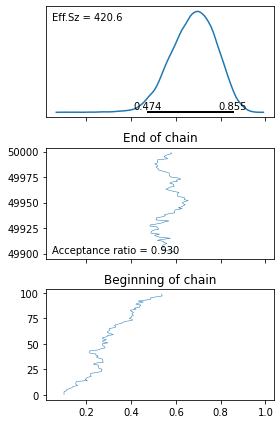

In [5]:
plot_utils.trace(trace_proposal_sd002)

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9b193670>,
       dtype=object))

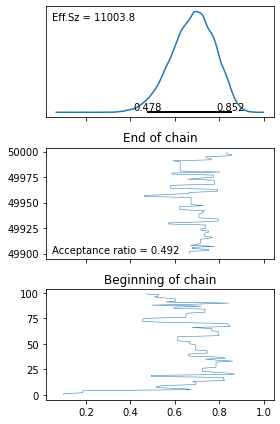

In [6]:
plot_utils.trace(trace_proposal_sd02)

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9aa12f70>,
       dtype=object))

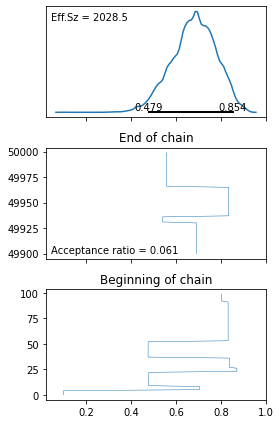

In [7]:
plot_utils.trace(trace_proposal_sd2)

# Exercise 2

Rewrite some of Kruschke's analysis plots in python and use them with the traces from the previous exercise.

In [8]:
def plot_trace_lag_analysis(trace, example_lags=[2, 5, 10], max_lag=30):

    autocorrelation = {lag: mcmc_utils.acf(trace, lag) for lag in range(1, max_lag + 1)}

    plt.figure(figsize=(10, 10))

    # Plot results for different lags
    for column, lag in enumerate(example_lags, start=1):

        # Lag example plots of traces and spread
        truncated_trace = trace[:100]
        head_trace = truncated_trace[:-lag]
        tail_trace = truncated_trace[lag:]

        # Plotting
        ax = plt.subplot(3, len(example_lags), column)
        ax.plot(head_trace)
        ax.plot(tail_trace)
        ax.set_title(f'Lag = {lag}')

        ax = plt.subplot(3, len(example_lags), column + len(example_lags))
        ax.scatter(tail_trace, head_trace)
        ax.set_title(f'ACF({lag}) = {autocorrelation[lag]:.3f}')
        ax.set_xlabel('lagged value')
        ax.set_ylabel('value')

    # Autocorrelation function plotting
    ax = plt.subplot(3, 1, 3)
    ax.bar(autocorrelation.keys(), autocorrelation.values())
    ax.set_xlim([1, max_lag])
    ax.set_title('Trace autocorrelation function')
    ax.set_xlabel('lag')
    ax.set_ylabel('autocorrelation')

    plt.tight_layout()

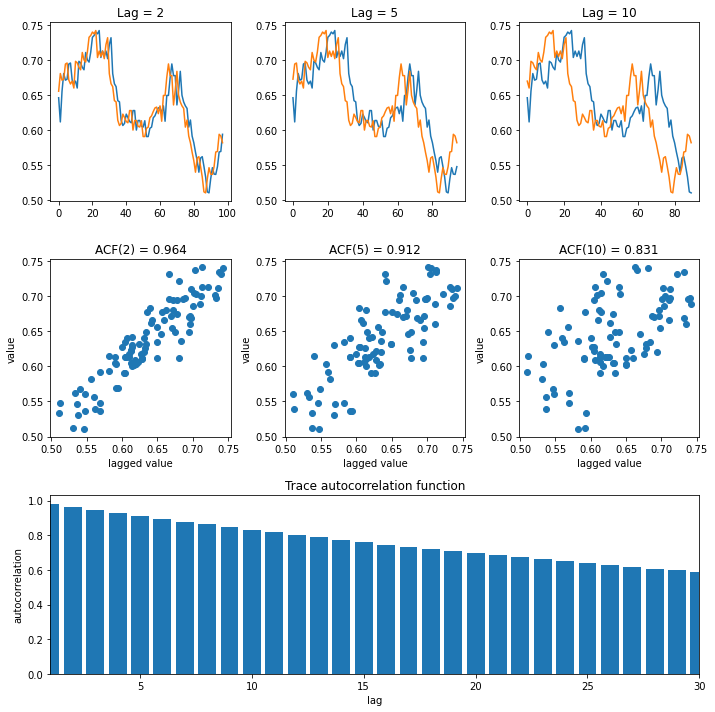

In [9]:
plot_trace_lag_analysis(trace_proposal_sd002[1000:])

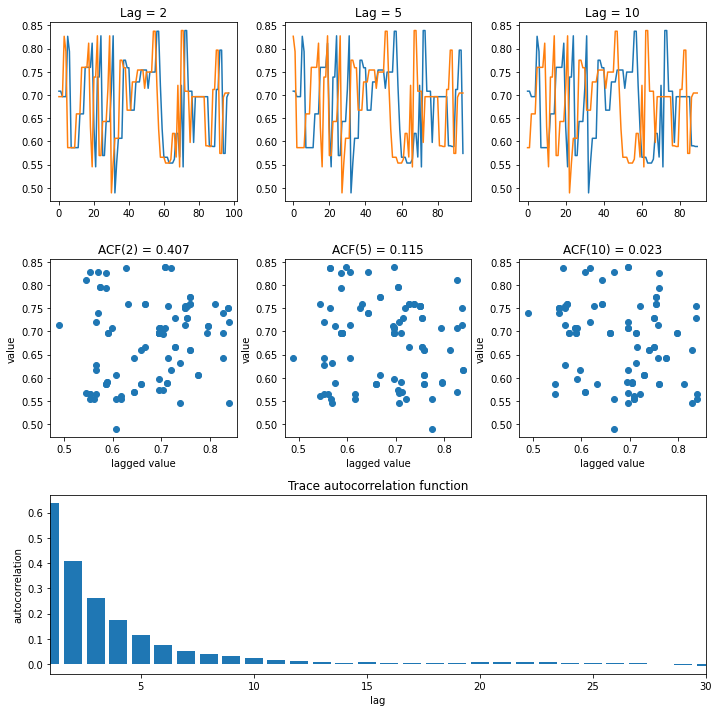

In [10]:
plot_trace_lag_analysis(trace_proposal_sd02[1000:])

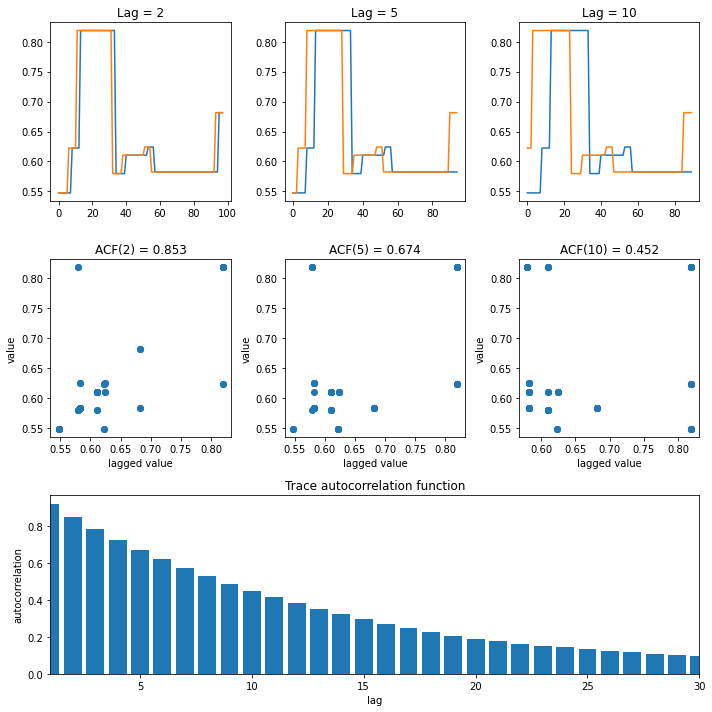

In [11]:
plot_trace_lag_analysis(trace_proposal_sd2[1000:])

# Exercise 3

Understand multimodal prior effects on the posterior through traces analysis.

### Questions A + B

Define a trimodal prior and plot it.

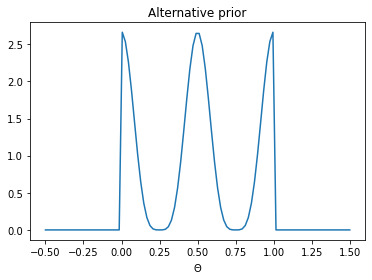

In [12]:
def prior(theta):
    window = stats.distributions.uniform.pdf(theta)
    return window * (np.cos(4 * np.pi * theta) + 1) ** 2 / 1.5

x = np.linspace(-0.5, 1.5, 100)
plt.plot(x, prior(x))
plt.title('Alternative prior')
_ = plt.xlabel('$\Theta$')

### Question C

Sampling from the prior.

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9a3e15e0>,
       dtype=object))

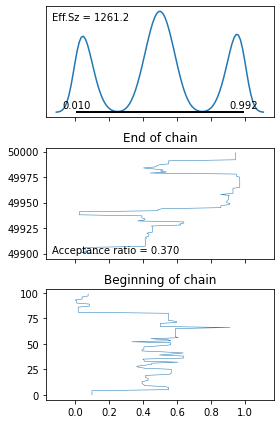

In [13]:
trace = np.array(list(metropolis_gen(prior, proposal_sd=0.2)))
plot_utils.trace(trace)

### Question D

Sampling from the posterior.

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d98a5b4f0>,
       dtype=object))

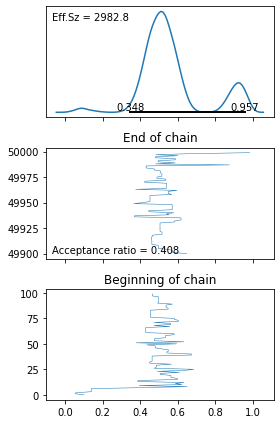

In [14]:
data = [0, 1, 1]
posterior = lambda theta: bern_likelihood(theta, data) * prior(theta)

trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.2)))
plot_utils.trace(trace)

### Question E

Same as the above, but with narrower proposal distribution. Notice how the algorithm get stuck on some of the modes of the trimodal prior.

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9a5e36d0>,
       dtype=object))

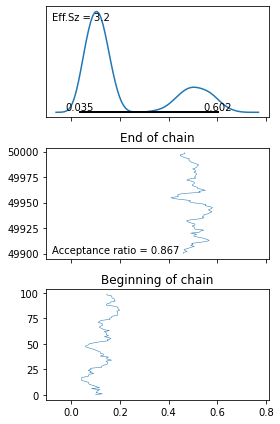

In [15]:
trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.02)))
plot_utils.trace(trace)

This chain is not representative of the underlying distribution. A way to check that is by generating multiple chains with different starting positoins and check for convergence (Gelman-Rubin statistic, or visual check).

### Question F

Same as before (too small proposal standard deviation), but now with another starting point. The result posterior is completely different, as the algorithm now stucked at another mode of the prior.

(<Figure size 288x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9a8c6c70>,
       dtype=object))

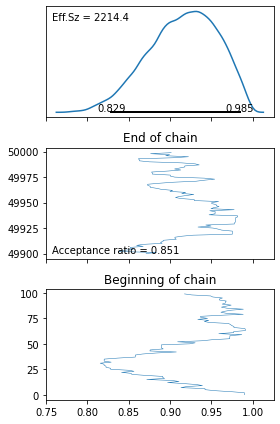

In [16]:
trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.02, starting_position=0.99)))
plot_utils.trace(trace)